# 기상데이터 모델링 분석

사용할 분석 모델 : Logistic regression, Random Forest, Support Vector Machine

## 라이브러리 불러오기

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import joblib
import numpy as np
from sklearn.inspection import permutation_importance
from scipy.spatial import cKDTree
import os

In [84]:
! python -m pip install --upgrade pandas


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------------------- -------------- 7.1/11.0 MB 36.4 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3


  You can safely remove it manually.
  You can safely remove it manually.


## 데이터 불러오기

### 기상 정보 데이터

In [3]:
weather_data = pd.read_csv("./data/weather_fire_label.csv", encoding='cp949')

In [16]:
weather_data

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),실효습도,산불
0,12,안면도(감),2022-01-01 00:00:00,-4.5,34.0,2.6,0.0,59.0,17.70,0
1,12,안면도(감),2022-01-01 01:00:00,-4.6,37.8,2.4,0.0,58.0,29.79,0
2,12,안면도(감),2022-01-01 02:00:00,-5.0,62.6,2.7,0.0,65.0,31.68,0
3,12,안면도(감),2022-01-01 03:00:00,-5.0,68.4,2.9,0.0,54.0,29.85,0
4,12,안면도(감),2022-01-01 04:00:00,-4.9,65.6,2.7,0.0,51.0,26.64,0
...,...,...,...,...,...,...,...,...,...,...
16418967,996,화동,2024-12-31 19:00:00,-0.5,268.2,3.1,0.0,38.0,18.96,0
16418968,996,화동,2024-12-31 20:00:00,-0.8,266.5,3.8,0.0,38.0,19.38,0
16418969,996,화동,2024-12-31 21:00:00,-1.6,262.5,5.2,0.0,46.0,21.78,0
16418970,996,화동,2024-12-31 22:00:00,-2.4,263.6,3.9,0.0,55.0,26.16,0


### 기상 관측 지점 데이터

In [17]:
loc_data = pd.read_csv("./data/meta-loc-edited.csv", encoding='cp949')

In [18]:
loc_data

,지점,시작일,종료일,지점명,위도,경도
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167
1,96,2020-10-23,NaN,독도,37.2395,131.8698
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640
3,144,1993-03-16,2011-12-09,군산(레),36.0123,126.7834
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000
...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099
569,994,2022-05-02,NaN,심포,35.8545,126.6421
570,995,2023-12-19,NaN,오천,35.9286,129.3822


In [19]:
loc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점      572 non-null    int64  
 1   시작일     572 non-null    object 
 2   종료일     26 non-null     object 
 3   지점명     572 non-null    object 
 4   위도      572 non-null    float64
 5   경도      572 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 26.9+ KB


In [20]:
loc_gdf = gpd.GeoDataFrame(
    loc_data, geometry=gpd.points_from_xy(loc_data['경도'], loc_data['위도']), crs="EPSG:4326"
)

In [21]:
loc_gdf

,지점,시작일,종료일,지점명,위도,경도,geometry
0,12,2007-11-30,NaN,안면도(감),36.5333,126.3167,POINT (126.3167 36.5333)
1,96,2020-10-23,NaN,독도,37.2395,131.8698,POINT (131.8698 37.2395)
2,116,2023-10-21,NaN,관악(레),37.4453,126.9640,POINT (126.964 37.4453)
3,144,1993-03-16,2011-12-09,군산(레),36.0123,126.7834,POINT (126.7834 36.0123)
4,160,2020-10-23,NaN,부산(레),35.1188,129.0000,POINT (129 35.1188)
...,...,...,...,...,...,...,...
567,992,2021-11-10,NaN,하빈,35.9062,128.4464,POINT (128.4464 35.9062)
568,993,2024-04-06,NaN,제주금악,33.3423,126.3099,POINT (126.3099 33.3423)
569,994,2022-05-02,NaN,심포,35.8545,126.6421,POINT (126.6421 35.8545)
570,995,2023-12-19,NaN,오천,35.9286,129.3822,POINT (129.3822 35.9286)


### 읍면동 위치 데이터

In [ ]:
emd_gdf = gpd.read_file("./data/emd.shp", encoding='euc-kr')
emd_gdf.geometry = emd_gdf.geometry.set_crs('EPSG:5179')
emd_gdf.geometry = emd_gdf.geometry.to_crs('EPSG:4326')

In [ ]:
emd_gdf

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110102,Singyo-dong,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((126.974 37.58654, 126.97401 37.58653..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110105,Changseong-dong,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."
...,...,...,...,...
5060,51830310,Seo-myeon,서면,"POLYGON ((128.40425 38.09607, 128.40504 38.096..."
5061,51830320,Sonyang-myeon,손양면,"MULTIPOLYGON (((128.67444 38.08345, 128.67444 ..."
5062,51830330,Hyeonbuk-myeon,현북면,"MULTIPOLYGON (((128.73582 38.01976, 128.73582 ..."
5063,51830340,Hyeonnam-myeon,현남면,"MULTIPOLYGON (((128.80236 37.92274, 128.80333 ..."


## 데이터 전처리


### 읍면동 중심점 계산

In [ ]:
emd_gdf['centroid'] = emd_gdf['geometry'].centroid

C:\Users\apffg\AppData\Local\Temp\ipykernel_14936\774085893.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  emd_gdf['centroid'] = emd_gdf['geometry'].centroid


In [ ]:
emd_centroid_gdf = emd_gdf[['EMD_CD', 'EMD_KOR_NM', 'geometry', 'centroid']]

In [ ]:
emd_centroid_gdf

,EMD_CD,EMD_KOR_NM,geometry,centroid
0,11110101,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589...",POINT (126.96932 37.58921)
1,11110102,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584...",POINT (126.96794 37.58451)
2,11110103,궁정동,"POLYGON ((126.974 37.58654, 126.97401 37.58653...",POINT (126.97271 37.5847)
3,11110104,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582...",POINT (126.97195 37.58267)
4,11110105,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581...",POINT (126.97247 37.58056)
...,...,...,...,...
5060,51830310,서면,"POLYGON ((128.40425 38.09607, 128.40504 38.096...",POINT (128.52505 38.01095)
5061,51830320,손양면,"MULTIPOLYGON (((128.67444 38.08345, 128.67444 ...",POINT (128.65234 38.04738)
5062,51830330,현북면,"MULTIPOLYGON (((128.73582 38.01976, 128.73582 ...",POINT (128.64613 37.9503)
5063,51830340,현남면,"MULTIPOLYGON (((128.80236 37.92274, 128.80333 ...",POINT (128.73845 37.93897)


<Axes: >

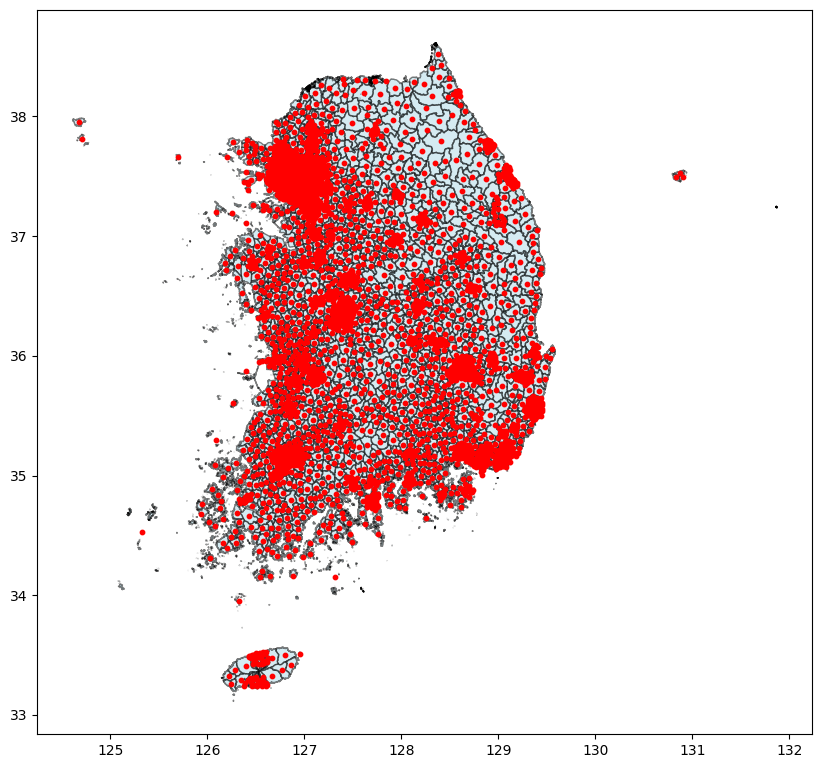

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

emd_gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.5, label='읍면동 경계')
emd_gdf['centroid'].plot(ax=ax, color='red', marker='o', markersize=10, label='읍면동 중심점')

### 기상 지점 -> 읍면동 데이터로 매핑 (미완)

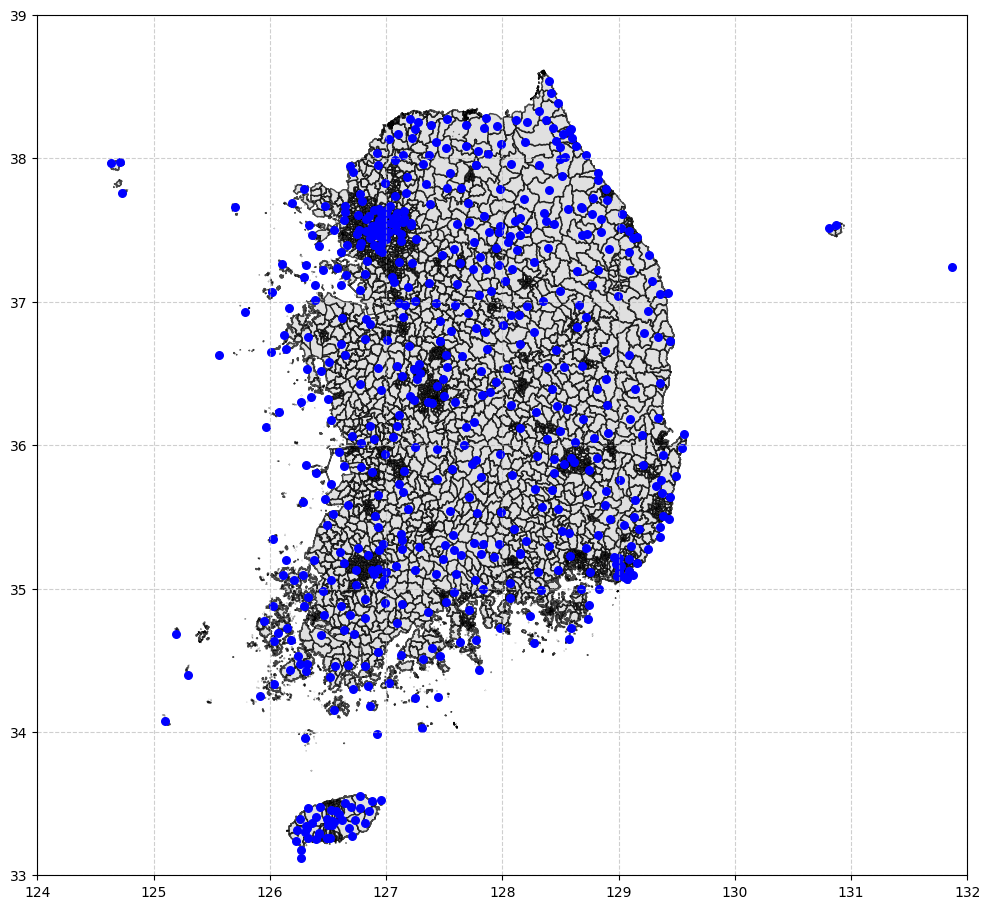

In [ ]:
# 읍면동 경계와 기상 관측 지점 비교
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
emd_gdf.plot(ax=ax, edgecolor='black', facecolor='lightgray', alpha=0.7, label='읍면동 경계')
loc_gdf.plot(ax=ax, color='blue', marker='o', markersize=30, label='기상 관측 지점')
ax.set_xlim([124, 132])
ax.set_ylim([33, 39])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# 나중에 지우기!!!!!
# loc_data는 station_gdf로 취급됨

In [100]:
# 읍면동에 포함된 지점 찾기
emd_with_stations = gpd.sjoin(loc_gdf, emd_centroid_gdf, how="inner", predicate="within")
emd_station_mapping_contained = emd_with_stations[['EMD_CD', '지점']]

emd_contained_stations = emd_station_mapping_contained.groupby('EMD_CD')['지점'].apply(list).reset_index()
emd_contained_stations.rename(columns={'지점': 'Contained_Stations'}, inplace=True)

In [101]:
len(emd_contained_stations)

505

In [102]:
# 지점이 포함되지 않은 읍면동 찾기
all_emd_cds = emd_centroid_gdf['EMD_CD'].unique()
contained_emd_cds_set = set(emd_contained_stations['EMD_CD'].unique())
emd_with_no_stations_set = set(all_emd_cds) - contained_emd_cds_set

In [104]:
# 가장 가까운 지점 찾기
emd_station_mapping_nearest = pd.DataFrame()
emd_no_stations_gdf = emd_centroid_gdf[emd_centroid_gdf['EMD_CD'].isin(emd_with_no_stations_set)].copy()

In [106]:
station_coords = np.array(list(zip(loc_gdf.geometry.x, loc_gdf.geometry.y)))
tree = cKDTree(station_coords)

emd_coords = np.array(list(zip(emd_no_stations_gdf.centroid.x, emd_no_stations_gdf.centroid.y)))
distances, indices = tree.query(emd_coords, k=1)

C:\Users\apffg\AppData\Local\Temp\ipykernel_14936\1064203663.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  emd_coords = np.array(list(zip(emd_no_stations_gdf.centroid.x, emd_no_stations_gdf.centroid.y)))


In [107]:
emd_station_mapping_nearest = pd.DataFrame({
        'EMD_CD': emd_no_stations_gdf['EMD_CD'].values,
        'Nearest_Station_Index': indices
    })

In [109]:
emd_station_mapping_nearest['Nearest_Station'] = loc_gdf.iloc[emd_station_mapping_nearest['Nearest_Station_Index']]['지점'].values
emd_station_mapping_nearest = emd_station_mapping_nearest[['EMD_CD', 'Nearest_Station']]

In [110]:
emd_station_mapping_nearest

,EMD_CD,Nearest_Station
0,11110101,422
1,11110102,422
2,11110103,422
3,11110104,422
4,11110105,422
...,...,...
4555,51820253,553
4556,51820320,517
4557,51820330,554
4558,51830320,670


In [111]:
# 지점을 포함한 읍면동에 대해 데이터 매핑
final_mapping_list = []
for index, row in emd_contained_stations.iterrows():
    emd_cd = row['EMD_CD']
    stations = row['Contained_Stations']
    for station in stations:
        final_mapping_list.append({'EMD_CD': emd_cd, 'Original_Station_Code': station, 'Mapping_Type': 'contained'})

In [112]:
# 가까운 지점에 대해 데이터 매핑
for index, row in emd_station_mapping_nearest.iterrows():
        emd_cd = row['EMD_CD']
        station = row['Nearest_Station']
        if emd_cd not in contained_emd_cds_set:
             final_mapping_list.append({'EMD_CD': emd_cd, 'Original_Station_Code': station, 'Mapping_Type': 'nearest'})

In [113]:
final_mapping_df = pd.DataFrame(final_mapping_list)

In [114]:
final_mapping_df

,EMD_CD,Original_Station_Code,Mapping_Type
0,11110182,420,contained
1,11110183,422,contained
2,11140142,419,contained
3,11170129,415,contained
4,11200114,421,contained
...,...,...,...
5119,51820253,553,nearest
5120,51820320,517,nearest
5121,51820330,554,nearest
5122,51830320,670,nearest


In [ ]:
# 기상정보데이터 매핑 (사이즈 너무 커서 청크 이용 + 임시파일에 저장)
weather_cols = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)', '실효습도', '산불']
id_cols = ['지점', '일시']
all_weather_cols = id_cols + weather_cols
chunk_size = 500000
temp_nearest_output_path = 'temp_nearest_results.csv'

In [ ]:
contained_aggregations = {}
chunk_iterator = pd.read_csv(
        "./data/weather_fire_label.csv",
        chunksize=chunk_size,
        encoding='cp949',
        parse_dates=['일시'],
        usecols=all_weather_cols
    )

In [ ]:
# MEMORY ERROR

mapping_indexed = final_mapping_df.set_index('Original_Station_Code')
chunk_count = 0
for chunk in chunk_iterator:
    chunk_count += 1
    print(f"청크 {chunk_count} 처리 중 (행 수: {len(chunk)})...")

    merged_chunk = chunk.merge(
        mapping_indexed,
        left_on='지점',
        right_index=True,
        how='left'
    )
    merged_chunk = merged_chunk.drop(columns=['지점'])

    # 'nearest' 데이터 처리
    nearest_chunk = merged_chunk[merged_chunk['Mapping_Type'] == 'nearest'].copy()
    if not nearest_chunk.empty:
        nearest_chunk = nearest_chunk[['EMD_CD', '일시'] + weather_cols]
        nearest_chunk = nearest_chunk.rename(columns={'EMD_CD': '지점'})
        header = not os.path.exists(temp_nearest_output_path)
        nearest_chunk.to_csv(temp_nearest_output_path, mode='a', header=header, index=False)

    # 'contained' 타입 데이터 처리
    contained_chunk = merged_chunk[merged_chunk['Mapping_Type'] == 'contained'].copy()
    if not contained_chunk.empty:
        contained_chunk = contained_chunk[['EMD_CD', '일시'] + weather_cols]

        chunk_agg = contained_chunk.groupby(['EMD_CD', '일시'])[weather_cols].agg(['sum', 'count'])

        for (emd_cd, 일시), row in chunk_agg.iterrows():
            key = (emd_cd, 일시) 
            if key not in contained_aggregations:
                contained_aggregations[key] = {'sum': {col: 0.0 for col in weather_cols},
                                               'count': {col: 0 for col in weather_cols}}

            for col in weather_cols:
                contained_aggregations[key]['sum'][col] += row[(col, 'sum')]
                contained_aggregations[key]['count'][col] += row[(col, 'count')]
        

In [ ]:
print("\n'contained' 매핑 데이터 최종 평균 계산 중...")
contained_results_list = []
# 누적된 합계와 개수를 사용하여 최종 평균을 계산합니다.
for (emd_cd, 일시), agg_data in contained_aggregations.items():
    result_row = {'지점': emd_cd, '일시': 일시}
    for col in weather_cols:
        total_sum = agg_data['sum'][col]
        total_count = agg_data['count'][col]
        # 개수가 0이 아닌 경우에만 평균 계산 (나누기 0 방지)
        result_row[col] = total_sum / total_count if total_count > 0 else np.nan # 데이터가 없는 경우 NaN으로 처리

    contained_results_list.append(result_row)

In [ ]:
contained_results_df = pd.DataFrame(contained_results_list)
# '일시' 컬럼이 datetime 타입인지 확인하고 필요시 변환 (concat 시 타입 일치 중요)
if not pd.api.types.is_datetime64_any_dtype(contained_results_df['일시']):
     contained_results_df['일시'] = pd.to_datetime(contained_results_df['일시'])

print("'contained' 매핑 데이터 최종 평균 계산 완료.")
print(f"'contained' 결과 행 수: {len(contained_results_df)}")


In [ ]:
print("\n'nearest' 매핑 결과 로드 중...")
if os.path.exists(temp_nearest_output_path):
    # 임시 파일에서 'nearest' 결과를 읽어옵니다.
    nearest_results_df = pd.read_csv(temp_nearest_output_path, parse_dates=['일시'])
    print("'nearest' 매핑 결과 로드 완료.")
    print(f"'nearest' 결과 행 수: {len(nearest_results_df)}")
    # 임시 파일 삭제 (선택 사항) - 최종 결과 파일 저장 후 삭제해도 됩니다.
    # os.remove(temp_nearest_output_path)
    # print(f"임시 파일 '{temp_nearest_output_path}' 삭제 완료.")
else:
    # 임시 파일이 없는 경우 (nearest 매핑 대상이 없었거나 오류 발생) 빈 DataFrame 생성
    nearest_results_df = pd.DataFrame(columns=['지점', '일시'] + weather_cols)
    print("'nearest' 매핑 결과 파일이 없습니다. (nearest 매핑 대상이 없었을 수 있습니다.)")

In [ ]:
# 최종 결과 합치기
print("\n최종 결과 합치는 중...")
# 'contained' 결과와 'nearest' 결과를 합칩니다.
final_result_df = pd.concat([contained_results_df, nearest_results_df], ignore_index=True)

# 결과 정렬 (선택 사항: EMD_CD, 일시 순으로 정렬하면 보기 좋습니다)
print("결과 정렬 중...")
final_result_df = final_result_df.sort_values(by=['지점', '일시']).reset_index(drop=True)
print("결과 정렬 완료.")

In [ ]:
# 최종 결과 확인 (미리보기)
print("\n--- 최종 결과 미리보기 (Pandas DataFrame) ---")
print(final_result_df.head())
print(f"최종 결과 총 행 수: {len(final_result_df)}")

In [ ]:
# 최종 결과를 CSV 파일로 저장
output_csv_path = 'weather_data_mapped_to_emd_pandas_chunking.csv'
print(f"\n최종 결과를 '{output_csv_path}' 파일로 저장합니다.")
try:
    final_result_df.to_csv(output_csv_path, index=False)
    print(f"데이터 매핑 및 저장이 완료되었습니다. 결과는 '{output_csv_path}' 파일에 저장되었습니다.")
except Exception as e:
    print(f"최종 결과 저장 중 오류 발생: {e}")

### 테스트 데이터 분리

In [5]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)', '실효습도']
X = weather_data[features]
y = weather_data['산불']

In [6]:
# 학습용 / 테스트 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

In [7]:
# data feature scailing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 랜덤 언더 샘플링 적용

In [8]:
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_train_scaled, y_train)

In [9]:
print(f"언더샘플링 학습 데이터 사이즈 : {X_res_under.shape}")
print(f"언더샘플링 산불 발생 데이터 (1) 개수 : {y_res_under.sum()}개")
print(f"언더샘플링 산불 미발생 데이터 (0) 개수 : {(y_res_under == 0).sum()}개")

언더샘플링 학습 데이터 사이즈 : (14910, 6)
언더샘플링 산불 발생 데이터 (1) 개수 : 7455개
언더샘플링 산불 미발생 데이터 (0) 개수 : 7455개


In [10]:
# 모델 학습
model_under = LogisticRegression(solver='liblinear', random_state=42)
model_under.fit(X_res_under, y_res_under)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [11]:
# 확률 예측
proba_under = model_under.predict_proba(X_test_scaled)[:, 1]

In [12]:
y_pred_under = model_under.predict(X_test_scaled)

In [13]:
# 모델 평가
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under))
print(f"AUC-ROC (Under-sampling): {roc_auc_score(y_test, proba_under):.4f}")
print(f"Recall (Under-sampling): {recall_score(y_test, y_pred_under):.4f}")

[[2400911  881020]
 [    491    1373]]
              precision    recall  f1-score   support

           0       1.00      0.73      0.84   3281931
           1       0.00      0.74      0.00      1864

    accuracy                           0.73   3283795
   macro avg       0.50      0.73      0.42   3283795
weighted avg       1.00      0.73      0.84   3283795

AUC-ROC (Under-sampling): 0.8054
Recall (Under-sampling): 0.7366


### SMOTE 적용

In [14]:
sm = SMOTE(random_state=42)
X_res_smote, y_res_smote = sm.fit_resample(X_train_scaled, y_train)

In [15]:
print(f"SMOTE 학습 데이터 사이즈 : {X_res_smote.shape}")
print(f"SMOTE 산불 발생 데이터 (1) 개수 : {y_res_smote.sum()}개")
print(f"SMOTE 산불 미발생 데이터 (0) 개수 : {(y_res_smote == 0).sum()}개")

SMOTE 학습 데이터 사이즈 : (26255444, 6)
SMOTE 산불 발생 데이터 (1) 개수 : 13127722개
SMOTE 산불 미발생 데이터 (0) 개수 : 13127722개


In [16]:
# 모델 학습
model_smote = LogisticRegression(solver='liblinear', random_state=42)
model_smote.fit(X_res_smote, y_res_smote)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [17]:
# 확률 예측
proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]

In [18]:
y_pred_smote = model_smote.predict(X_test_scaled)

In [19]:
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))
print(f"AUC-ROC (SMOTE): {roc_auc_score(y_test, proba_smote):.4f}")
print(f"Recall (SMOTE): {recall_score(y_test, y_pred_smote):.4f}")

[[2392340  889591]
 [    486    1378]]
              precision    recall  f1-score   support

           0       1.00      0.73      0.84   3281931
           1       0.00      0.74      0.00      1864

    accuracy                           0.73   3283795
   macro avg       0.50      0.73      0.42   3283795
weighted avg       1.00      0.73      0.84   3283795

AUC-ROC (SMOTE): 0.8051
Recall (SMOTE): 0.7393


## Random Forest

### 언더샘플링 적용

In [20]:
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_train_scaled, y_train)

In [21]:
print(f"언더샘플링 학습 데이터 사이즈 : {X_res_under.shape}")
print(f"언더샘플링 산불 발생 데이터 (1) 개수 : {y_res_under.sum()}개")
print(f"언더샘플링 산불 미발생 데이터 (0) 개수 : {(y_res_under == 0).sum()}개")

언더샘플링 학습 데이터 사이즈 : (14910, 6)
언더샘플링 산불 발생 데이터 (1) 개수 : 7455개
언더샘플링 산불 미발생 데이터 (0) 개수 : 7455개


In [22]:
# 모델 학습
model_under = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_under.fit(X_res_under, y_res_under)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
proba_under = model_under.predict_proba(X_test_scaled)[:, 1]

In [24]:
y_pred_under = model_under.predict(X_test_scaled)

In [25]:
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under))
print(f"AUC-ROC (Under-sampling): {roc_auc_score(y_test, proba_under):.4f}")
print(f"Recall (Under-sampling): {recall_score(y_test, y_pred_under):.4f}")

[[2533759  748172]
 [    348    1516]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87   3281931
           1       0.00      0.81      0.00      1864

    accuracy                           0.77   3283795
   macro avg       0.50      0.79      0.44   3283795
weighted avg       1.00      0.77      0.87   3283795

AUC-ROC (Under-sampling): 0.8777
Recall (Under-sampling): 0.8133


### SMOTE 적용


In [26]:
sm = SMOTE(random_state=42)
X_res_smote, y_res_smote = sm.fit_resample(X_train_scaled, y_train)

In [27]:
print(f"SMOTE 학습 데이터 사이즈 : {X_res_smote.shape}")
print(f"SMOTE 산불 발생 데이터 (1) 개수 : {y_res_smote.sum()}개")
print(f"SMOTE 산불 미발생 데이터 (0) 개수 : {(y_res_smote == 0).sum()}개")

SMOTE 학습 데이터 사이즈 : (26255444, 6)
SMOTE 산불 발생 데이터 (1) 개수 : 13127722개
SMOTE 산불 미발생 데이터 (0) 개수 : 13127722개


In [ ]:
# Random Forest 모델 학습 (시간 상당히 소요)
model_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_smote.fit(X_res_smote, y_res_smote)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
# 확률 예측
proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]
y_pred_smote = model_smote.predict(X_test_scaled)

In [39]:
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))
print(f"AUC-ROC (SMOTE): {roc_auc_score(y_test, proba_smote):.4f}")
print(f"Recall (SMOTE): {recall_score(y_test, y_pred_smote):.4f}")

[[3281545     386]
 [   1267     597]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3281931
           1       0.61      0.32      0.42      1864

    accuracy                           1.00   3283795
   macro avg       0.80      0.66      0.71   3283795
weighted avg       1.00      1.00      1.00   3283795

AUC-ROC (SMOTE): 0.7752
Recall (SMOTE): 0.3203


In [ ]:
# feature importance 확인
importance_smote = pd.Series(model_smote.feature_importances_, index=features).sort_values(ascending=False)
print(importance_smote)

습도(%)      0.291539
실효습도       0.233199
풍속(m/s)    0.192306
기온(°C)     0.162299
풍향(deg)    0.110642
강수량(mm)    0.010016
dtype: float64


In [29]:
model_smote_filename = 'random_forest_smote_model.joblib'

In [ ]:
# SMOTE 이용해 학습한 Random forest 모델 저장
joblib.dump(model_smote, model_smote_filename)

['random_forest_smote_model.joblib']

In [30]:
# 모델 불러오기 테스트
load_model = joblib.load(model_smote_filename)
predictions = load_model.predict(X_test_scaled)
probabilities = load_model.predict_proba(X_test_scaled)[:, 1]

In [31]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(f"AUC-ROC (SMOTE): {roc_auc_score(y_test, probabilities):.4f}")
print(f"Recall (SMOTE): {recall_score(y_test, predictions):.4f}")

[[3281545     386]
 [   1267     597]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3281931
           1       0.61      0.32      0.42      1864

    accuracy                           1.00   3283795
   macro avg       0.80      0.66      0.71   3283795
weighted avg       1.00      1.00      1.00   3283795

AUC-ROC (SMOTE): 0.7752
Recall (SMOTE): 0.3203


## Support Vector Machine

### 언더샘플링

In [32]:
rus = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_train_scaled, y_train)

In [33]:
print(f"언더샘플링 학습 데이터 사이즈 : {X_res_under.shape}")
print(f"언더샘플링 산불 발생 데이터 (1) 개수 : {y_res_under.sum()}개")
print(f"언더샘플링 산불 미발생 데이터 (0) 개수 : {(y_res_under == 0).sum()}개")

언더샘플링 학습 데이터 사이즈 : (14910, 6)
언더샘플링 산불 발생 데이터 (1) 개수 : 7455개
언더샘플링 산불 미발생 데이터 (0) 개수 : 7455개


In [34]:
# 모델 학습
model_under = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
model_under.fit(X_res_under, y_res_under)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [35]:
# 확률 예측
proba_under = model_under.predict_proba(X_test_scaled)[:, 1]
y_pred_under = model_under.predict(X_test_scaled)

In [36]:
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under))
print(f"AUC-ROC (Under-sampling): {roc_auc_score(y_test, proba_under):.4f}")
print(f"Recall (Under-sampling): {recall_score(y_test, y_pred_under):.4f}")

[[2449837  832094]
 [    466    1398]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.85   3281931
           1       0.00      0.75      0.00      1864

    accuracy                           0.75   3283795
   macro avg       0.50      0.75      0.43   3283795
weighted avg       1.00      0.75      0.85   3283795

AUC-ROC (Under-sampling): 0.8191
Recall (Under-sampling): 0.7500


In [ ]:
result = permutation_importance(model_under, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importance_means = result.importances_mean
feature_names=['습도(%)', '실효습도', '풍속(m/s)', '기온(°C)', '풍향(deg)', '강수량(mm)']
feature_importance = pd.Series(importance_means, index=feature_names).sort_values(ascending=False)

In [ ]:
print(feature_importance)

### SMOTE

In [9]:
sm = SMOTE(random_state=42)
X_res_smote, y_res_smote = sm.fit_resample(X_train_scaled, y_train)

In [10]:
print(f"SMOTE 학습 데이터 사이즈 : {X_res_smote.shape}")
print(f"SMOTE 산불 발생 데이터 (1) 개수 : {y_res_smote.sum()}개")
print(f"SMOTE 산불 미발생 데이터 (0) 개수 : {(y_res_smote == 0).sum()}개")

SMOTE 학습 데이터 사이즈 : (26255444, 6)
SMOTE 산불 발생 데이터 (1) 개수 : 13127722개
SMOTE 산불 미발생 데이터 (0) 개수 : 13127722개


In [ ]:
# SVC 모델 학습
model_smote = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
model_smote.fit(X_res_smote, y_res_smote) # 학습 시간이 너무 오래 걸려서 보류 !!

In [ ]:
# 확률 예측
proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]
y_pred_smote = model_smote.predict(X_test_scaled)

In [ ]:
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))
print(f"AUC-ROC (SMOTE): {roc_auc_score(y_test, proba_smote):.4f}")
print(f"Recall (SMOTE): {recall_score(y_test, y_pred_smote):.4f}")

In [ ]:
# SMOTE 이용해 학습한 SVC 모델 저장
model_smote_svc_filename = 'SVC_smote_model.joblib'
joblib.dump(model_smote, model_smote_svc_filename)

In [ ]:
# 모델 불러오기 테스트
load_model = joblib.load(model_smote_svc_filename)
predictions = load_model.predict(X_test_scaled)
probabilities = load_model.predict_proba(X_test_scaled)[:, 1]
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(f"AUC-ROC (SMOTE): {roc_auc_score(y_test, probabilities):.4f}")
print(f"Recall (SMOTE): {recall_score(y_test, predictions):.4f}")

## 산불예측지수 모델링


In [8]:
wildfire_index_data = pd.read_csv ("./data/result.csv", encoding='cp949')

In [9]:
wildfire_index_data

,EMD_CD,YYYYMMDDHH,risk,risks
0,11110101,2025040100,NaN,0.0
1,11110101,2025040101,NaN,0.0
2,11110101,2025040102,NaN,0.0
3,11110101,2025040103,NaN,0.0
4,11110101,2025040104,NaN,0.0
...,...,...,...,...
3636665,51830350,2025043019,NaN,2.0
3636666,51830350,2025043020,NaN,2.0
3636667,51830350,2025043021,NaN,1.0
3636668,51830350,2025043022,NaN,1.0
